<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/pytorch/blob/main/dl_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What you will learn in this notebook
 
1. Introduction to supervised learning and classification
1. Introduction to loss functions, activation functions, and gradient descent
1. Introduction to Pytorch packages, tensors, computation graphs, and gradients


## CIFAR10 Dataset

- We have already seen the CIFAR10 dataset
- We will use it to do binary classification

In [1]:
import torch 
import torchvision as vision

cifar10_train=vision.datasets.CIFAR10(".",download=True,train=True)# train=True is the default
cifar10_test=vision.datasets.CIFAR10(".",download=True,train=False)

Files already downloaded and verified
Files already downloaded and verified


### Data transforms
- Recall from last session that CIFAR10 contains a set of images/labels
- To use the dataset with PyTorch we need to **transform** the data to tensors

In [2]:
# create an iterator to the dataset
itr=iter(cifar10_train)
img0,label0=next(itr)
print(type(img0),type(label0))

<class 'PIL.Image.Image'> <class 'int'>


In [3]:
from torchvision.transforms import ToTensor
cifar10_train=vision.datasets.CIFAR10(".",download=True,train=True,transform=ToTensor())
cifar10_test=vision.datasets.CIFAR10(".",download=True,train=False,transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


### Binary classification

- The dataset has 10 classes: Airplanes,Cars,Birds,Cats,Deers,Dogs,Frogs,Horses, Ships and Trucks
- For simplicity we will rearrange it into only 2 classes
    - "Living things"
    - "Machines

In [4]:
#airplane=0,car=1,bird=2,cat=3,deer=4,dog=5,frog=6,horse=7,ship=8,truck=9
features=torch.tensor([0,1,8,9])
for i, (img,label) in enumerate(cifar10_train):
    if torch.isin(label,features):
        cifar10_train.targets[i]=1
    else:
        cifar10_train.targets[i]=0
for i, (img,label) in enumerate(cifar10_test):
    if torch.isin(label,features):
        cifar10_test.targets[i]=1
    else:
        cifar10_test.targets[i]=0

### Stochastic gradient descent

- So far the gradient was computed using the whole dataset
- In many situations this is not feasible
- A good approximation is stochastic gradient descent
- The gradient is computed for a single sample
- Most commonly the gradient is computed over a batch (or mini-batch)

### Data loader
- Mini-batch gradient descent is more efficient when the batches are randomly selected
- PyTorch provides a convenient class for operations on batches: ```DataLoader```

In [5]:
from torch.utils.data import DataLoader
batch_size=32
train_loader=DataLoader(cifar10_train,batch_size=batch_size,num_workers=2)
test_loader=DataLoader(cifar10_test,batch_size=batch_size,num_workers=2)



In [6]:
itr=iter(train_loader)
imgs,labels=next(itr)
print(type(imgs),labels.dtype)
print(imgs.shape,labels.shape)

<class 'torch.Tensor'> torch.int64
torch.Size([32, 3, 32, 32]) torch.Size([32])




## Logistic Regression

- Logistic Regression which can be regarded as the **simplest neural network**, a single "neuron". 

As can be seen from the figure below the input is a vector of size _n_ and it feeds a single unit (a neuron or perceptron). To obtain the output we perform the **dot** product between the matrix **W** and the input **x** and the result is fed into some function (usually nonlinear) _f_

$$
\begin{align*}
z&=\sum_iw_i\cdot x_i+b\\
\hat{y}(x)&=f(z)
\end{align*}
$$

Since $z$ depends on $w$ and $b$ so does $\hat{y}$. The input and _f_ are known whereas _W_ and _b_ are parameters to be determined. Our goal is to find the _optimal_ _W_ and _b_ such that the output is as *close as possible* to the label associated with the input.
![title](https://github.com/hikmatfarhat-ndu/CSC645/blob/master/figures/perceptron.png?raw=1)

How is **as close as possible** defined? The dataset is usually a set of pairs $(x,y)$. We define the loss as the **deviation** between the label $y$ and the result $\hat{y}=f(z)$

$$loss=E_{w,b}(y,\hat{y})$$

The function $E$ depends on the problem (for example binary cross entropy, mean squared error,...)

Note that $E$ depends on the parameters $w,b$. Our goal is to find the **optimal** $w,b$ such that the loss is minimal. From calculus we know that to find the minimum (max) of a function we compute its derivative and find where it is null.

## Sigmoid

So far we have not specified the function _f_ that our  model depends on $\hat{y}=f(z)$. In this example we use the **sigmoid** function. Given an input _z_ it has the form

$$
\begin{align*}
\sigma=\frac{1}{1+e^{-z}}
\end{align*}
$$

We can plot the sigmoid function using matplotlib. As you can see below the values of $\sigma$ go from 0 to 1 which we interpret as a probability. For example, if $\sigma=0.65$ then the probability of the image being a **ship** is 0.65 and of **not** being one is 0.35 so decide it is a ship.


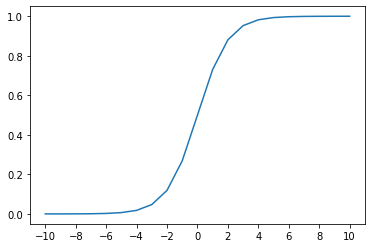

In [7]:
import numpy as np
import matplotlib.pyplot as plt
z=[1/(1+np.exp(-x)) for x in range(-10,11)]
plt.plot([x for x in range(-10,11)],z)
plt.xticks([t for t in range(-10,11,2)])
plt.show()

## Flatening the images
The images have dimensions (3,32,32) (3 channels, 32 height,32 width). To feed them to our "neuron" we need to create a vector of dimension 3x32x32

In [8]:
itr=iter(train_loader)
imgs,labels=next(itr)
imgs=imgs.reshape(batch_size,-1)
print(imgs.shape,labels.shape)
torch.unique(labels)

torch.Size([32, 3072]) torch.Size([32])


tensor([0, 1])

As mentioned before, to simplify the problem, we group all "machines" together by giving them the label 1 and all living things together by giving them the label 0

## Initialize the parameters
Our goal is to find the **optimal** values for the parameters, weights and bias. Intially we give them random values (for weights) and 0 for the bias as shown below. Note two things
1. We divide the initial values of the weights by the total number of samples to minimize the possibility of divergence.
1. The `reguires_grad` declares a tensor to be a variable, i.e. we need the derivative. In previous versions of Pytorch one needed to declare variables explicitly but this is deprecated now. See [here](https://pytorch.org/docs/stable/autograd.html#variable-deprecated)

In [9]:
weights=torch.randn(3*32*32,requires_grad=True,dtype=torch.float32)
bias=torch.tensor(0.,requires_grad=True,dtype=torch.float32)

In [10]:
loss_fn=torch.nn.BCELoss()
itr=iter(train_loader)
imgs,labels=next(itr)
imgs=imgs.flatten(start_dim=1)
y_hat=torch.matmul(imgs,weights)+bias
y_hat=torch.sigmoid(y_hat)
loss=loss_fn(y_hat,labels.float())
print(loss)

tensor(8.5975, grad_fn=<BinaryCrossEntropyBackward0>)


## Optimization loop

In [11]:
rate=0.015
loss_fn=torch.nn.BCELoss()
epochs=10
for epoch in range(epochs):
    for imgs,labels in train_loader:
        imgs=imgs.flatten(start_dim=1)
        y_hat=torch.matmul(imgs,weights)+bias
        y_hat=torch.sigmoid(y_hat)
        loss=loss_fn(y_hat,labels.float())
        dw,db=torch.autograd.grad(loss,[weights,bias])
        #update the weights and bias
        weights.data-=rate*dw
        bias.data-=rate*db

  
    print("loss {:.4f}".format(loss.item()))

loss 3.3057
loss 2.5578
loss 2.1809
loss 1.9531
loss 1.7920
loss 1.6611
loss 1.5507
loss 1.4555
loss 1.3734
loss 1.3015


## Prediction on the test data

An important measure of any ML method is how well it "generalizes". This is done by using the trained model on test data, i.e. other than the data it was trained on. To do that we note that the output of our model is the probability that the input is a "machine", which could be any value between 0 and 1. The test labels are discrete values of 0 and 1 so how do we compare them? We regard a probability $\ge 0.5$ to be 1 and $< 0.5$ to be 0

In [12]:
def predict(loader):
    total=0.
    for imgs,labels in loader:
        imgs=imgs.flatten(start_dim=1)
        y_hat=torch.matmul(imgs,weights)+bias
        y_hat=torch.sigmoid(y_hat)
        ones=y_hat>0.5
        r=ones==labels
        total+=r.sum()
    # Compute vector "y_hat" predicting
    # the probabilities of a machine being present in the picture
    
    return total/len(loader.dataset)

In [13]:
predict(test_loader)

tensor(0.7483)

## Abstracting the model and training pipeline using Pytorch

- The model we have used  is simple enough to code directly. 
- We only needed Pytorch to compute the gradients. 
- When more complicated models are used this process becomes unwieldy. 
- We can use Pytorch to abstract away the details.  
- The abstractions offered by Pytorch are illustrated below to solve the same problem that we just did. 

### The model

- The model we plan to use is encapsulated in a class that **inherits** from ```torch.nn.Module```

- All we need to do is **override** two methods:
1. ```__init__```. As you would have guess this is called when the object is constructed to initialize our model
1. ``` forward```. This is called everytime a forward computation is needed

In [14]:
seed=0
torch.manual_seed(seed)
batch_size=32
train_loader=DataLoader(cifar10_train,batch_size=batch_size,num_workers=2)
test_loader=DataLoader(cifar10_test,batch_size=batch_size,num_workers=2)

import torch.nn as nn

class Net(nn.Module):
  def __init__(self,in_features,out_features):
    super(Net, self).__init__()
    self.input_size=in_features
    self.output_size=out_features
    # declaring weights and bias as parameters so that they are included
    # in the return value of .parameters()
    self.weights=nn.Parameter(torch.randn(in_features,requires_grad=True,dtype=torch.float32))
    #self.weights.data/=in_features
    self.bias=nn.Parameter(torch.tensor(0.,requires_grad=True,dtype=torch.float32))
    #self.layer=nn.Linear(self.input_size,self.output_size,bias=True)
  def forward(self,input):  
    y_hat=input.flatten(start_dim=1)
    y_hat=torch.matmul(y_hat,self.weights)+self.bias
    y_hat=torch.sigmoid(y_hat)
    return y_hat

- Note that in the initialization, the weights and bias are constructed as ```Parameter```. 
- This is so that we can use the ```.parameters()``` call and pass it to the optimizer.
- Next we create an instance of the model

In [15]:
model=Net(3*32*32,1)

In [16]:
itr=iter(train_loader)
imgs,labels=next(itr)
outputs=model(imgs)
loss=loss_fn(outputs,labels.float())
print(loss)

tensor(3.8617, grad_fn=<BinaryCrossEntropyBackward0>)


Recall that each learning iteration performs a number of steps. 
1. Compute the forward pass over the input to get the output. This is now done using ```model.forward()``` indirectly by calling ```model(input)```
1. Compute the loss using an appropriate loss function. Same as before
1. Compute the gradients. Now we use ```loss.backward()```.
    - Not only it computes the gradient with respect to the parameters but saves those values in the parameters themselves. 
    - For example, if ```p``` is a parameters then ```loss.backward()``` computes the gradient and saves it in ```p.grad```
1. Update the parameters. This is done by the optimizer using ```optimizer.step()```. This is important since later on we will use optimizers that use a different strategy to update the parameters.

In [17]:
rate=0.015

import torch.optim as optim
optimizer=optim.SGD(model.parameters(),lr=rate)
loss_fn=torch.nn.BCELoss()
epochs=10
for epoch in range(epochs):
  for imgs,labels in train_loader:
  # uses the .forward() method to get y_hat
    y_hat=model(imgs)
  # as before
    loss=loss_fn(y_hat,labels.float())
  # Computes the gradients and saves them in the appropriate .grad
    loss.backward()
  # updates the parameters using the computed .grad
    optimizer.step()
  # zero the .grad values so that they don't accumulate
    optimizer.zero_grad()
  
  print("loss {:.4f}".format(loss.item()))

loss 1.9296
loss 1.4413
loss 1.2445
loss 1.1275
loss 1.0413
loss 0.9792
loss 0.9396
loss 0.9155
loss 0.8993
loss 0.8869


In [18]:
def predict(loader):
    total=0.
    for imgs,labels in loader:
        outputs=model(imgs)
        ones=outputs>0.5
        r=ones==labels
        total+=r.sum()
    # Compute vector "y_hat" predicting
    # the probabilities of a machine being present in the picture
    
    return total/len(loader.dataset)

In [19]:
predict(test_loader)

tensor(0.7566)